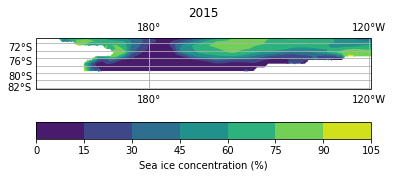

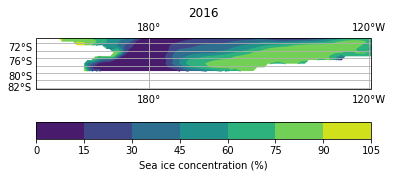

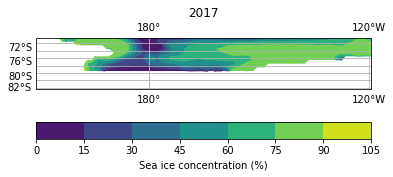

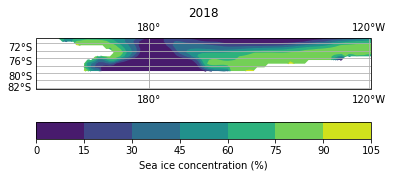

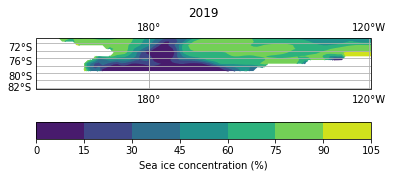

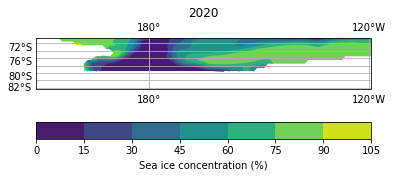

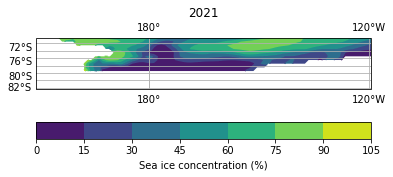

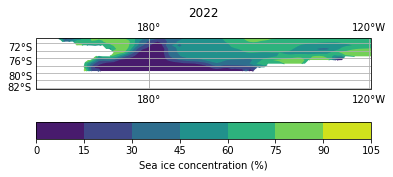

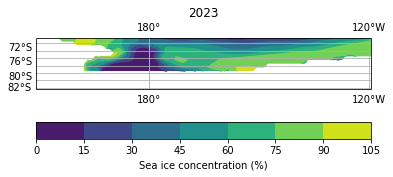

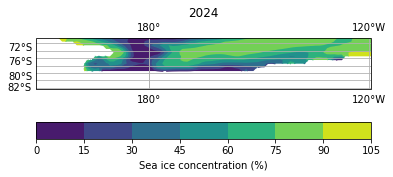

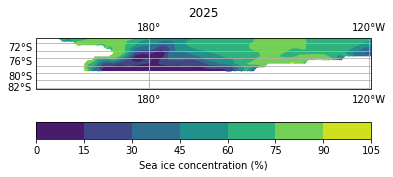

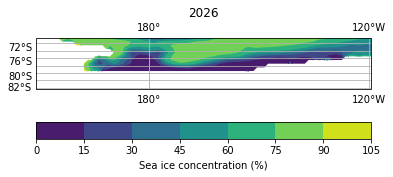

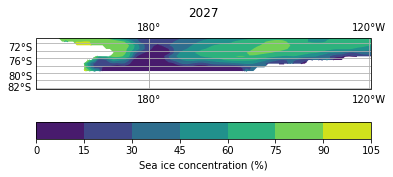

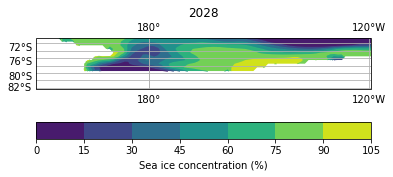

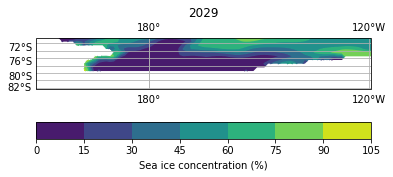

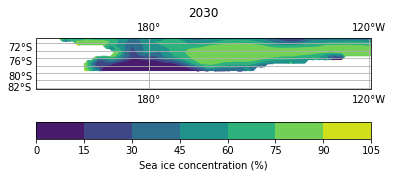

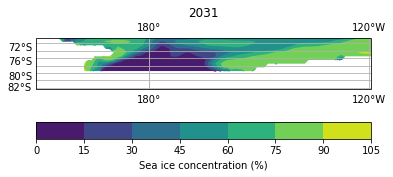

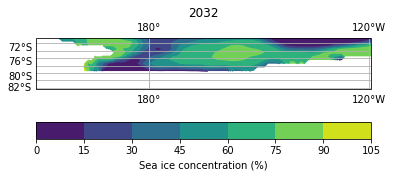

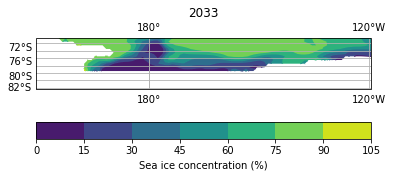

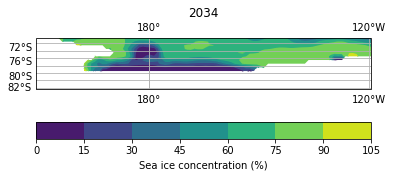

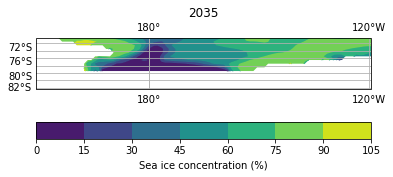

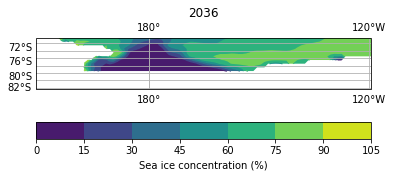

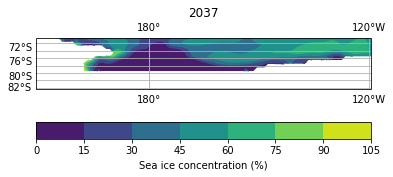

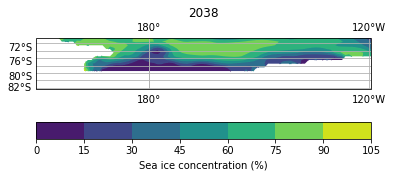

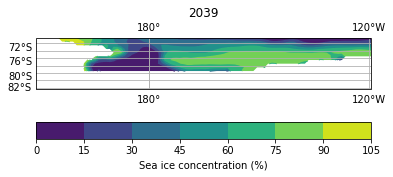

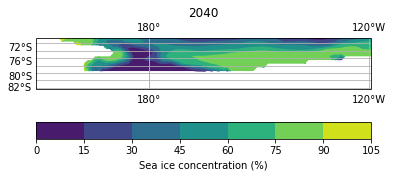

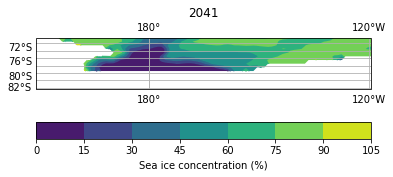

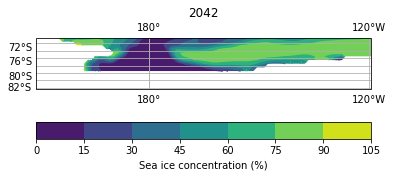

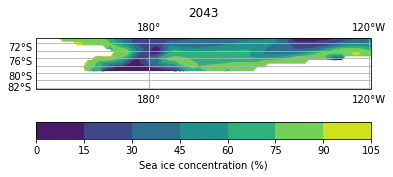

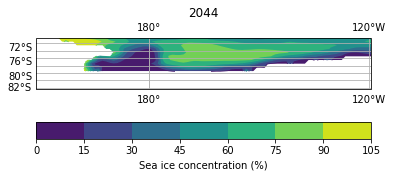

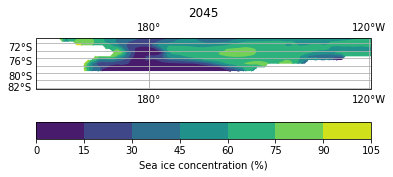

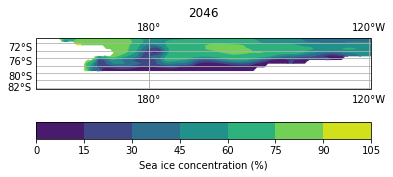

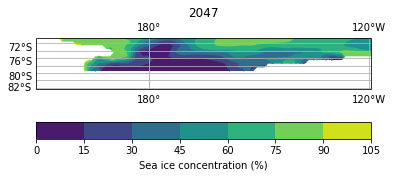

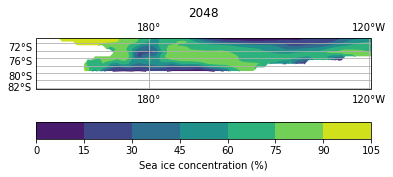

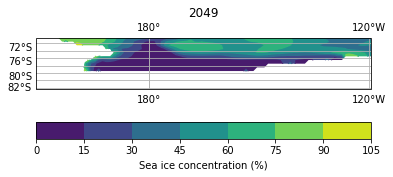

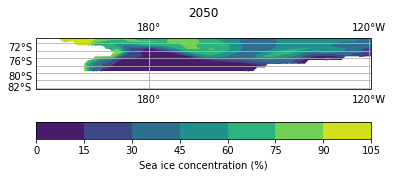

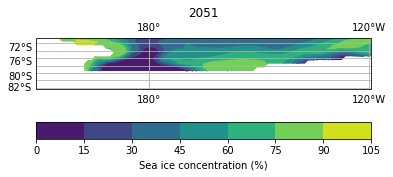

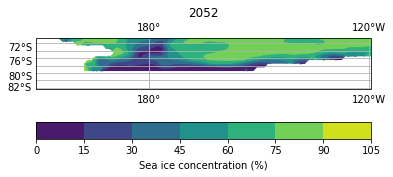

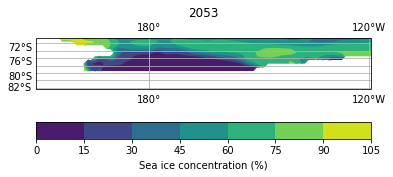

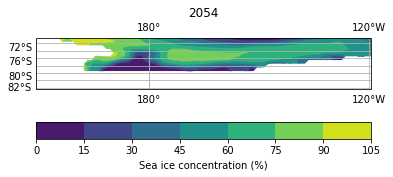

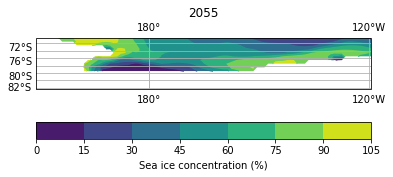

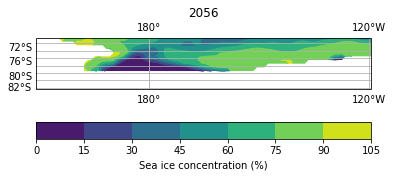

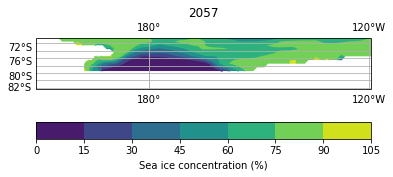

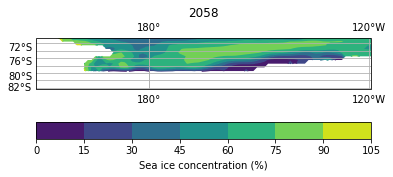

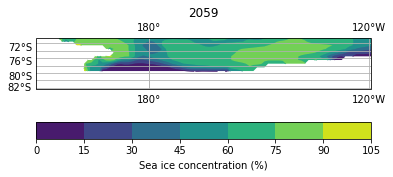

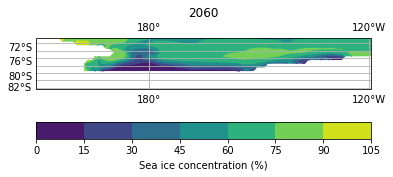

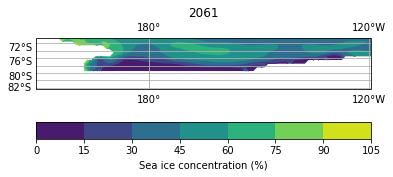

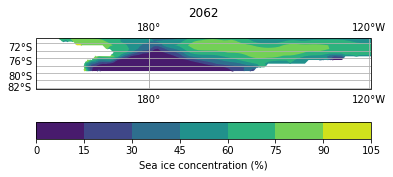

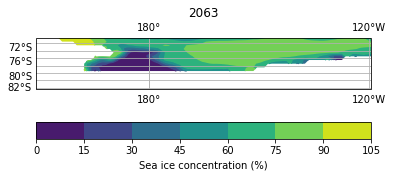

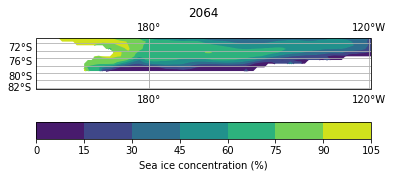

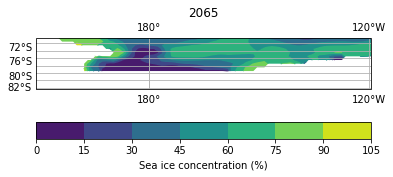

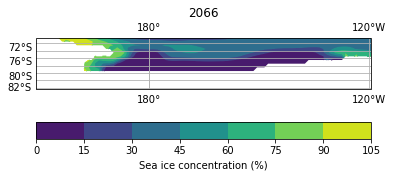

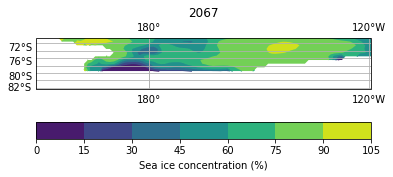

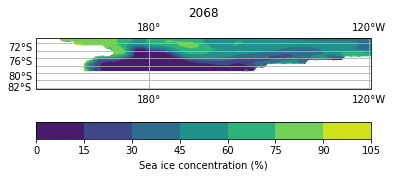

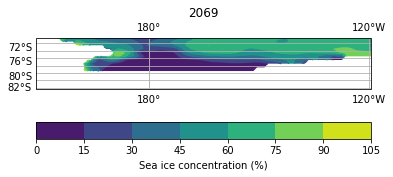

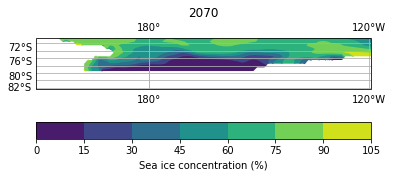

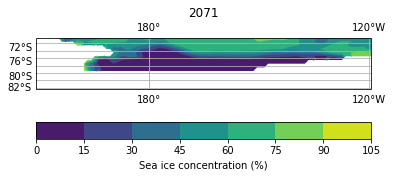

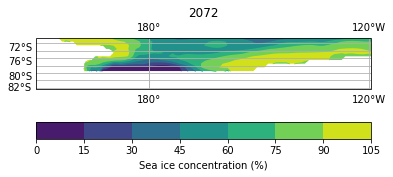

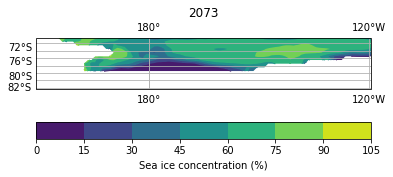

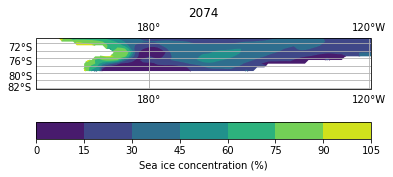

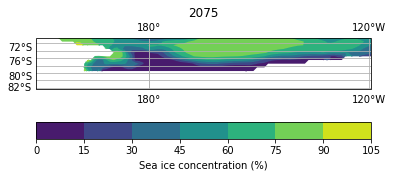

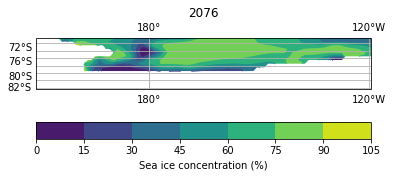

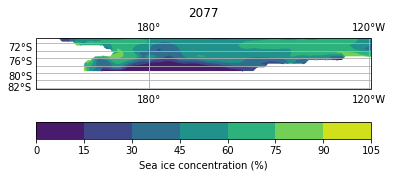

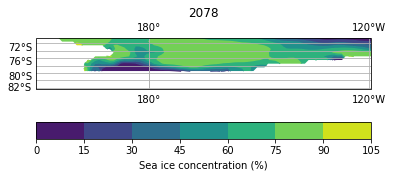

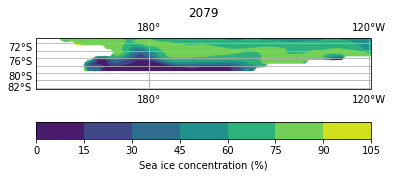

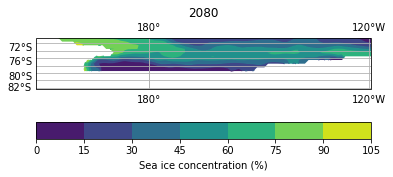

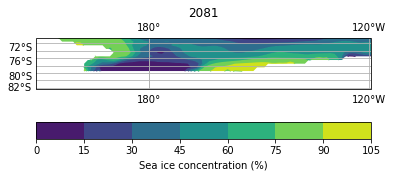

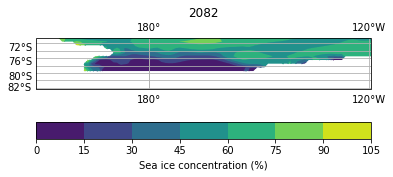

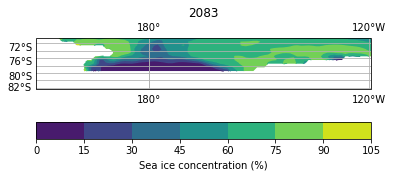

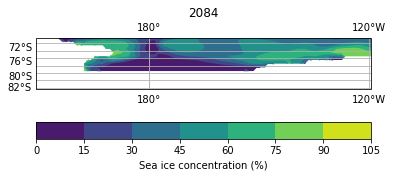

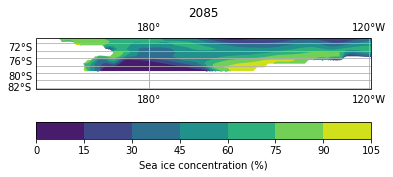

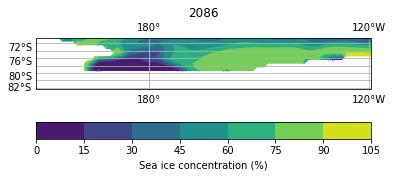

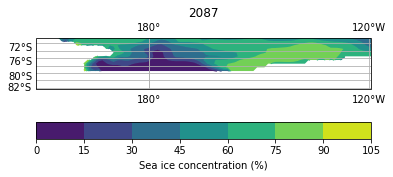

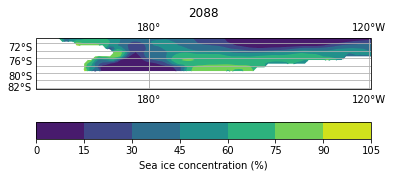

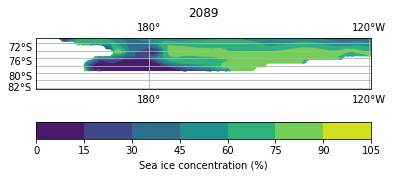

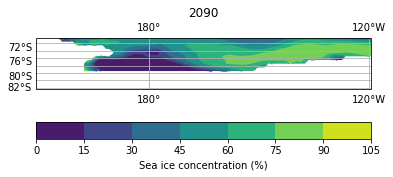

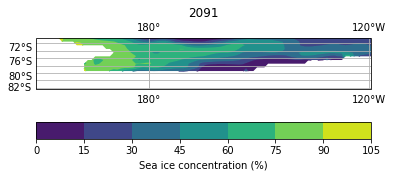

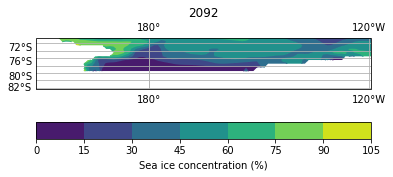

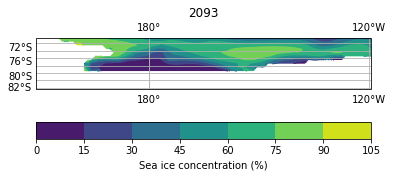

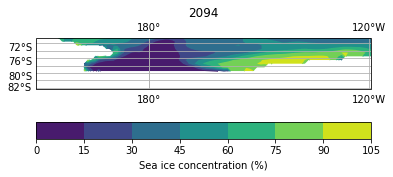

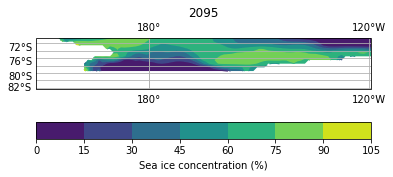

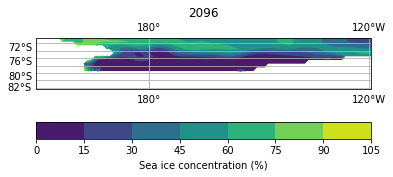

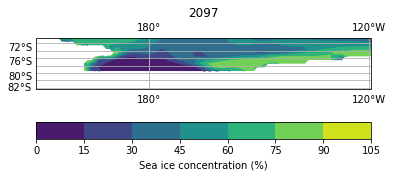

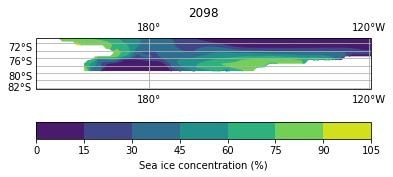

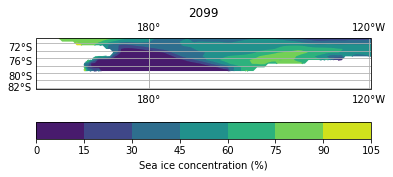

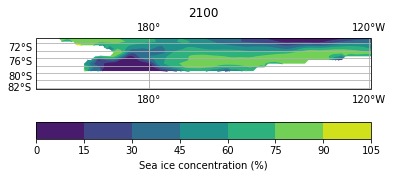

In [7]:
import cartopy.crs as ccrs
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
import iris.analysis.cartography
import iris.plot as iplt
import iris.quickplot as qplt
import numpy as np
import matplotlib.ticker as mticker 
from numpy import *
from iris.analysis import *
from iris.coord_categorisation import * 
from iris.analysis.cartography import * 
from scipy.stats import *
from scipy.stats.mstats import *
from iris import *

import warnings
warnings.filterwarnings("ignore")

fname = '/Users/alicebrindley/Downloads/siconc_SImon_GFDL-ESM4_ssp585_r1i1p1f1_gr_201501-210012.nc'
cube = iris.load(fname)

siconc=cube[2] 
add_month_number(siconc, 'time', name='month_number2')
cube2 = siconc[np.where((siconc.coord('month_number2').points == 12))]
#then to average this by each year, so that you have the December-Jan for
add_season_year(cube2, 'time', name='season_year')
#then average by the season year:
cube2.aggregated_by(['season_year'], iris.analysis.MEAN)

fgname = ('/Users/alicebrindley/Downloads/GFDL-esm-585-fgco2/outfile')
fgcube = iris.load(fgname)
fgcube1=fgcube[0] 

#extract Jan and Dec to average the sea ice concentration across these mon
add_month_number(fgcube1, 'time', name='month_number1')
fgcube2 = fgcube1[np.where((fgcube1.coord('month_number1').points == 12))]
#then to average this by each year, so that you have the December-Jan for
add_season_year(fgcube2, 'time', name='season_year')
#then average by the season year:
fgcube2.aggregated_by(['season_year'], iris.analysis.MEAN)
#cube2 is therefore the data per season


# Extract the regionan of interst across teh whole cube just once at that start
west = -210 
east = -120 
south = -82 
north = -69

temporary_cube = cube2.intersection(longitude = (west, east)) 
cube2 = temporary_cube.intersection(latitude = (south, north))

fg_temporary_cube = fgcube2.intersection(longitude = (west, east)) 
fgcube2 = fg_temporary_cube.intersection(latitude = (south, north))


#Make a 3D copy of the input cube to hold output
polynya_location_cube = cube2.copy()
#have a variable holding just the data from this to put processed data in
polynya_location_cube_data = polynya_location_cube.data
#not just set that all to missing data (nans) so that we know if we have data in it it is real data we want not just leftovers.
polynya_location_cube_data[:] = np.nan


#start of the loop
for i in range (0,2101-2015):
    regional_cube=cube2[i,:,:]
    ax1 = plt.subplot(111,projection=ccrs.PlateCarree(central_longitude=np.round(west + (east - west)/2.0)))
    my_plot = iplt.contourf(regional_cube)
    plt.gca().gridlines(draw_labels=True)
    plt.colorbar(orientation='horizontal', label='Sea ice concentration (%)')
    plt.title(2015+i)
    plt.savefig('polynya_locations')
    plt.show()

#extract the latitude I want to work with

    latitude = -72,-72.5,-73,-73.5,-74,-74.5,-75
    grid_areas = area_weights(regional_cube)
    average_variable = regional_cube.collapsed(['latitude', 'longitude'],MEAN,weights=grid_areas)
    #print(average_variable.data)
    
 
    if average_variable.data >=50:
        #define siconc for polynya
        polynya_threshold=regional_cube.data
        polynya = np.where((polynya_threshold.data <=20) & (average_variable.data >=50))
        #print(polynya)
        polynya = polynya_threshold.data
        #plt.pcolormesh(polynya_threshold.data,vmin=0,vmax=100)
        
        #plt.show()
        
        #threshold number you are interested in
        polynya_threshold_value = 20.0
        #copy of the seaice data to make a binary 'mask' showing presence of absense of polynyas as 1s and 0s
        polynya_location = polynya_threshold.data.copy()
        #set land data in this mask to nan (Not a number)
        polynya_location[np.where(polynya_location >= 1.0e9)] = np.nan
        #make water that has more ice than our polynia condition equal to zero.
        polynya_location[np.where((polynya_location <= 100.0) & (polynya_location > polynya_threshold_value))] = 0.0
        #make water that has less ice than our polynia condition equal to zero to make where the polynya is
        polynya_location[np.where((polynya_location > 0.0) & (polynya_location <= polynya_threshold_value))] = 1.0
        
        #Assign the data to that particular year in the 3D output array:
        polynya_location_cube_data[i,:,:] = polynya_location

        #plt.pcolormesh(polynya_location,vmin=0,vmax=1)
        #plt.show()
    
        
#array nack to hold all off the metadata etc.
polynya_location_cube.data = polynya_location_cube_data
        


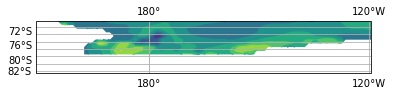

In [8]:
ax1 = plt.subplot(111,projection=ccrs.PlateCarree(central_longitude=np.round(west + (east - west)/2.0))) 
my_plot = iplt.contourf(fgcube2[0])
plt.gca().gridlines(draw_labels=True)

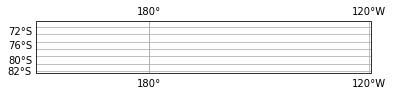

In [9]:
ax1 = plt.subplot(111,projection=ccrs.PlateCarree(central_longitude=np.round(west + (east - west)/2.0)))
my_plot = iplt.contourf(polynya_location_cube[0])
plt.gca().gridlines(draw_labels=True)

In [22]:
masked_co2_flux = polynya_location_cube * (fgcube2[0-86,:,:]*31536000000)

In [23]:
masked_co2_flux.data[np.logical_not(np.isfinite(masked_co2_flux.data))] = 0

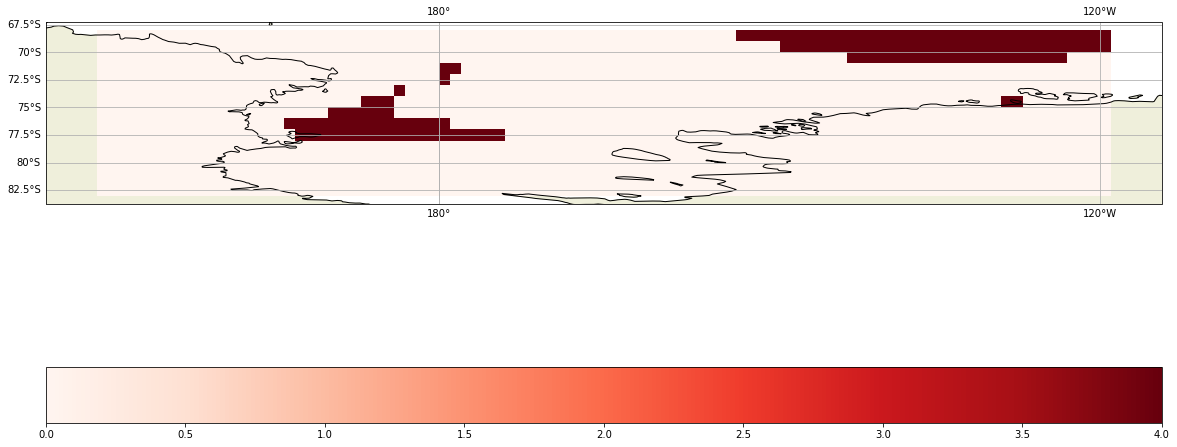

In [36]:
import cartopy.feature as cfeature 

time_slice = 13
plt.figure(figsize=(20,20))
ax1 = plt.subplot(111,projection=ccrs.PlateCarree(central_longitude=np.round(west + (east - west)/2.0))) # 
#my_plot = iplt.pcolormesh(fgcube2[time_slice],cmap='Reds',vmin=-3.0,vmax=2.0e-8)
#my_plot = iplt.pcolormesh(polynya_location_cube[time_slice],cmap='Reds',vmin=-8.0,vmax=2.0)
my_plot = iplt.pcolormesh(masked_co2_flux[time_slice],cmap='Reds',vmin=0.0,vmax=4.0) 
plt.gca().gridlines(draw_labels=True)
ax1.add_feature(cfeature.LAND)
ax1.add_feature(cfeature.COASTLINE)
plt.colorbar(orientation='horizontal')
plt.savefig('time_slice_13')

In [13]:
for i in range (0,2101-2015):
    output = np.nansum(polynya_location_cube_data[i,:,:])
    print(output)

0.0
0.0
91.0
0.0
123.0
164.0
0.0
0.0
108.0
114.0
105.0
171.0
0.0
134.0
0.0
89.0
148.0
139.0
113.0
97.0
118.0
154.0
0.0
114.0
0.0
113.0
132.0
176.0
88.0
146.0
124.0
135.0
153.0
82.0
0.0
0.0
93.0
113.0
0.0
111.0
64.0
73.0
113.0
78.0
79.0
71.0
0.0
155.0
81.0
122.0
103.0
0.0
34.0
0.0
0.0
149.0
0.0
43.0
88.0
0.0
167.0
38.0
0.0
68.0
98.0
0.0
0.0
0.0
94.0
0.0
108.0
78.0
111.0
0.0
91.0
124.0
0.0
0.0
119.0
0.0
0.0
0.0
0.0
0.0
0.0
99.0


In [25]:
def area_avg(cube): 
    try:
        cube.coord('latitude').guess_bounds() 
    except:
        pass 
    try:
        cube.coord('longitude').guess_bounds() 
    except:
        pass
    grid_areas = iris.analysis.cartography.area_weights(cube)
    return cube.collapsed(['longitude', 'latitude'],iris.analysis.MEAN, weights=grid_areas)

In [26]:
masked_co2_flux_timeseries = area_avg(masked_co2_flux)

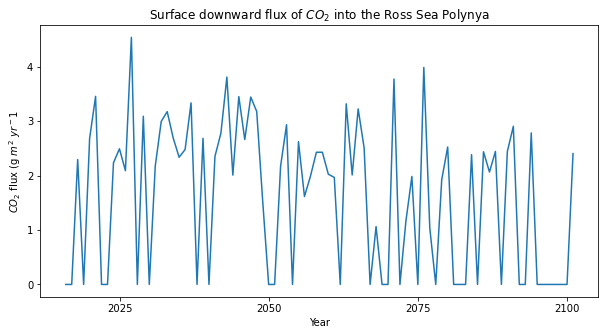

In [27]:
plt.figure(figsize=(10,5)) 
iplt.plot(masked_co2_flux_timeseries) 

plt.ylabel('$CO_2$ flux (g $m^2$ $yr^-1$')
plt.xlabel('Year')
plt.savefig('RSP_carbon_flux')
plt.title('Surface downward flux of $CO_2$ into the Ross Sea Polynya')
plt.savefig('polynya_flux_graph_correct')


In [28]:
print(masked_co2_flux_timeseries.data)

[0.0 0.0 2.2940958880995903 0.0 2.680176253008558 3.454803138726039 0.0
 0.0 2.235170903031946 2.4913552502053395 2.0890537439242736
 4.538452467040846 0.0 3.0893797320324 0.0 2.1749426686677924
 2.9941533122929354 3.174487860806247 2.6925739615972337 2.336254956126259
 2.4783542585669722 3.3350222758068147 0.0 2.6844513391400238 0.0
 2.350435784532597 2.779389138041175 3.8083995571584603 2.0081425435063354
 3.4507609899360463 2.66110266897048 3.442142937608721 3.176791360664005
 1.5336776002410337 0.0 0.0 2.1713969998643967 2.933909495068917 0.0
 2.6216996788245677 1.61566318268705 1.985751844263139 2.4281393625267147
 2.428166517835614 2.0245417035554083 1.9663471399170092 0.0
 3.3177913069199847 2.010677942335525 3.223687105010589 2.507403713634348
 0.0 1.0622358362980897 0.0 0.0 3.772351458764463 0.0 1.16389910138796
 1.9835054540610786 0.0 3.9857088099778077 1.0367415086421463 0.0
 1.9236481296269468 2.525016379714609 0.0 0.0 0.0 2.3842368849945834 0.0
 2.4371742082164327 2.064843

In [18]:
np.mean(masked_co2_flux_timeseries.data)

1.610529955638743